<h1 style="text-align: center;font-size: 36px;color:darkblue;">Modeling</h1>

# Imports

In [1]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as pyplot
import os
import pickle
import cv2
import keras
import tensorflow
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils.vis_utils import plot_model
import seaborn
import random

# Configurations

In [2]:
# %matplotlib qt;
%matplotlib inline
pyplot.rcParams["figure.figsize"] = (5, 3)

In [3]:
Training_Data_Path="../Data/Main_Data/train/"
Testing_Data_Path="../Data/Main_Data/valid/"

In [4]:
Object_Data_Path="../Data/Preprocessed_Data/"

In [5]:
class_list=os.listdir(Training_Data_Path)

In [6]:
class_list

['XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST']

In [7]:
input_dimension=(224, 224, 1)

# Model Implementaion

In [9]:
Architecture=keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=(224,224,1)),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
#     keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Reshape((162,128)),
    keras.layers.LSTM(128,return_sequences=True),
    keras.layers.LSTM(64,return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=len(class_list), activation='softmax')
    ]
 )

In [10]:
class Model_Traininer():
    @staticmethod
    def getNormalImagesData(folder_path,size=False,resize_dimension=(224,224)):
        Data=[]
        list_of_classes=os.listdir(folder_path)
        for class_name in list_of_classes:
            print(class_name)
            class_path=os.path.join(folder_path,class_name)
            counter=0
            for image_name in os.listdir(class_path):
                counter+=1
                print(counter,end=",")
                try:
                    image_array=cv2.imread(os.path.join(class_path,image_name),cv2.IMREAD_GRAYSCALE)
                    image_array=cv2.resize(image_array,resize_dimension)
                    Data.append([image_array,list_of_classes.index(class_name)])
                except Exception as e:
                    pass
                if size!=False and counter>=size:
                    break
            print()
            print("Total",counter,"Images is Readed")
        return Data
    @staticmethod
    def getClassificationEvaluation(actuals:list,predictions:list,labels:list):
        classification_data=confusion_matrix(
        [labels[i] for i in actuals],
        [labels[numpy.argmax(prediction)] for prediction in predictions]
        )
        seaborn.heatmap(classification_data,annot=True,xticklabels=labels, yticklabels=labels)
        pyplot.show()
        print(classification_report(
        [labels[i] for i in actuals],
        [labels[numpy.argmax(prediction)] for prediction in predictions]
        ))
    def saveData(self,Saving_Path,class_):
        pickle_training_features=open(Saving_Path+"/"+class_+"/pickle_training_features_1.pickle","wb")
        pickle.dump(self.Training_Features,pickle_training_features)
        pickle_training_features.close()
        pickle_training_labels=open(Saving_Path+"/"+class_+"/pickle_training_labels_1.pickle","wb")
        pickle.dump(self.Training_Labels,pickle_training_labels)
        pickle_training_labels.close()
        pickle_testing_features=open(Saving_Path+"/"+class_+"/pickle_testing_features_1.pickle","wb")
        pickle.dump(self.Testing_Features,pickle_testing_features)
        pickle_testing_features.close()
        pickle_testing_labels=open(Saving_Path+"/"+class_+"/pickle_testing_labels_1.pickle","wb")
        pickle.dump(self.Testing_Labels,pickle_testing_labels)
        pickle_testing_labels.close()
    def Preprocess_Training_Data(self,Training_Data_Path,training_ratio=0.8):
        class_list=os.listdir(Training_Data_Path)
        Training_Data=Model_Traininer.getNormalImagesData(Training_Data_Path)
        random.shuffle(Training_Data)
        self.Training_Features=[]
        self.Training_Labels=[]
        for image_array_value,label in Training_Data:
            self.Training_Features.append(image_array_value)
            self.Training_Labels.append(label)
        self.Training_Features=numpy.array(self.Training_Features)
        self.Training_Labels=numpy.array(self.Training_Labels)
        self.Training_Features=numpy.expand_dims(self.Training_Features,axis=-1)
    def Preprocess_testing_Data(self,Testing_Data_Path,training_ratio=0.8):
        class_list=os.listdir(Testing_Data_Path)
        Testing_Data=Model_Traininer.getNormalImagesData(Testing_Data_Path)
        random.shuffle(Testing_Data)
        self.Testing_Features=[]
        self.Testing_Labels=[]
        for image_array_value,label in Testing_Data:
            self.Testing_Features.append(image_array_value)
            self.Testing_Labels.append(label)        
        self.Testing_Features=numpy.array(self.Testing_Features)
        self.Testing_Labels=numpy.array(self.Testing_Labels)
        self.Testing_Features=numpy.expand_dims(self.Testing_Features,axis=-1)
    def SetTheModel(self,Model):
        self.model=Model
        self.model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        print(self.model.summary())
    def TrainTheModel(self,epoch=10):
        self.model.fit(
            self.Training_Features,self.Training_Labels,
            epochs=epoch,
            verbose=1,
            validation_data=(self.Testing_Features,self.Testing_Labels)
        )
    def EvaluateModel(self,class_list):
        Training_Predictions=self.model.predict(self.Training_Features)
        Testing_Predictions=self.model.predict(self.Testing_Features)
        print("Training Accuracy")
        Model_Traininer.getClassificationEvaluation(self.Training_Labels,Training_Predictions,class_list)
        print("Testing Accuracy")
        Model_Traininer.getClassificationEvaluation(self.Testing_Labels,Testing_Predictions,class_list)
    def saveTheModel(self,path):
        self.model.save(path)

In [11]:
def TrainTheModel(Architecture,epochs=5):
    for class_ in os.listdir("../Data/Main_Data/train/"):
        print(f"\n\n\nTraining for {class_}")
        Model=Model_Traininer()
        Model.Preprocess_Training_Data(f"../Data/Main_Data/train/{class_}")
        Model.Preprocess_testing_Data(f"../Data/Main_Data/valid/{class_}")
        Model.saveData(f"../Data/Preprocessed_Data/{class_}/","")
        print(Model.Training_Features.shape)
        print(Model.Training_Features.shape)
        Model.SetTheModel(Architecture)
        Model.TrainTheModel(epoch=epochs)
        Model.EvaluateModel(os.listdir(f"../Data/Main_Data/train/{class_}"))
        Model.saveTheModel(f"../Model/{class_}/DefinedModel.h5")




Training for XR_ELBOW
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,
Total 102 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,
Total 100 Images is Readed
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,
Total 50 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,

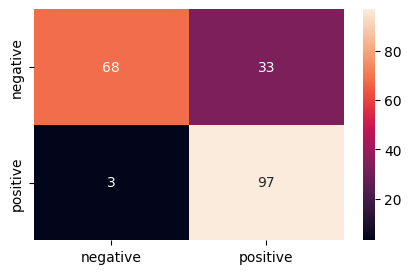

              precision    recall  f1-score   support

    negative       0.96      0.67      0.79       101
    positive       0.75      0.97      0.84       100

    accuracy                           0.82       201
   macro avg       0.85      0.82      0.82       201
weighted avg       0.85      0.82      0.82       201

Testing Accuracy


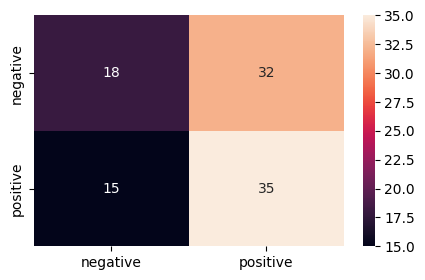

              precision    recall  f1-score   support

    negative       0.55      0.36      0.43        50
    positive       0.52      0.70      0.60        50

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.53      0.53      0.52       100




Training for XR_FINGER
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,
Total 100 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,
Total 101 Im

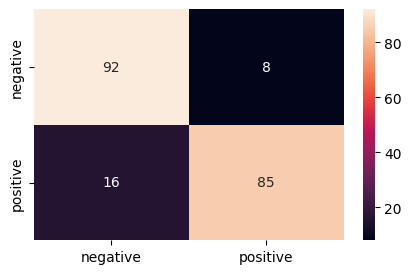

              precision    recall  f1-score   support

    negative       0.85      0.92      0.88       100
    positive       0.91      0.84      0.88       101

    accuracy                           0.88       201
   macro avg       0.88      0.88      0.88       201
weighted avg       0.88      0.88      0.88       201

Testing Accuracy


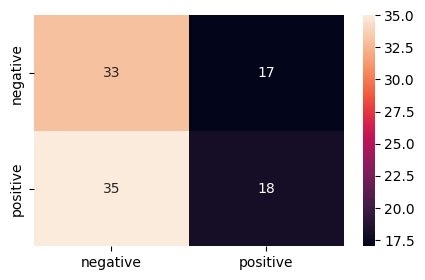

              precision    recall  f1-score   support

    negative       0.49      0.66      0.56        50
    positive       0.51      0.34      0.41        53

    accuracy                           0.50       103
   macro avg       0.50      0.50      0.48       103
weighted avg       0.50      0.50      0.48       103




Training for XR_FOREARM
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,
Total 101 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,
Tot

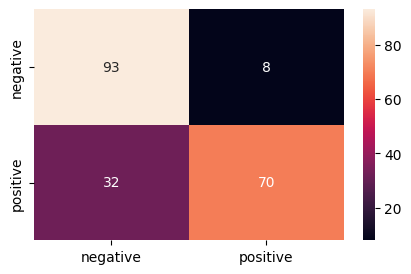

              precision    recall  f1-score   support

    negative       0.74      0.92      0.82       101
    positive       0.90      0.69      0.78       102

    accuracy                           0.80       203
   macro avg       0.82      0.80      0.80       203
weighted avg       0.82      0.80      0.80       203

Testing Accuracy


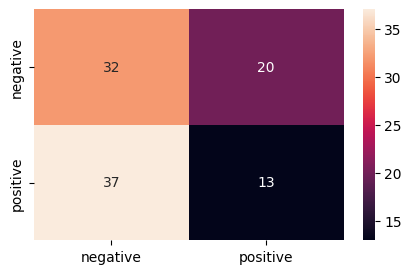

              precision    recall  f1-score   support

    negative       0.46      0.62      0.53        52
    positive       0.39      0.26      0.31        50

    accuracy                           0.44       102
   macro avg       0.43      0.44      0.42       102
weighted avg       0.43      0.44      0.42       102




Training for XR_HAND
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,
Total 102 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,
Total 97 Images is R

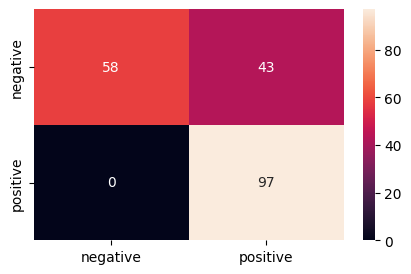

              precision    recall  f1-score   support

    negative       1.00      0.57      0.73       101
    positive       0.69      1.00      0.82        97

    accuracy                           0.78       198
   macro avg       0.85      0.79      0.77       198
weighted avg       0.85      0.78      0.77       198

Testing Accuracy


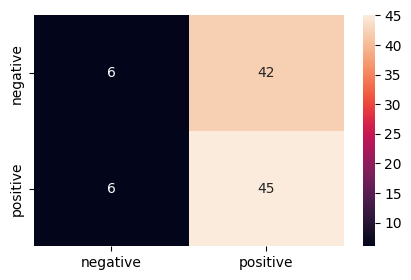

              precision    recall  f1-score   support

    negative       0.50      0.12      0.20        48
    positive       0.52      0.88      0.65        51

    accuracy                           0.52        99
   macro avg       0.51      0.50      0.43        99
weighted avg       0.51      0.52      0.43        99




Training for XR_HUMERUS
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
Total 99 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,
Total 100 Images is 

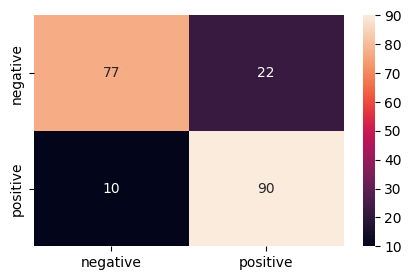

              precision    recall  f1-score   support

    negative       0.89      0.78      0.83        99
    positive       0.80      0.90      0.85       100

    accuracy                           0.84       199
   macro avg       0.84      0.84      0.84       199
weighted avg       0.84      0.84      0.84       199

Testing Accuracy


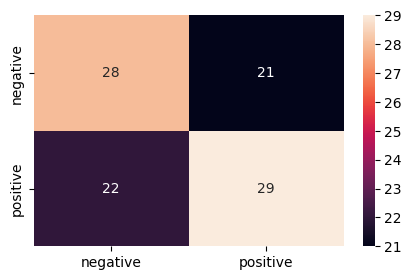

              precision    recall  f1-score   support

    negative       0.56      0.57      0.57        49
    positive       0.58      0.57      0.57        51

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100




Training for XR_SHOULDER
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,
Total 101 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,
Total 96 Images is Read

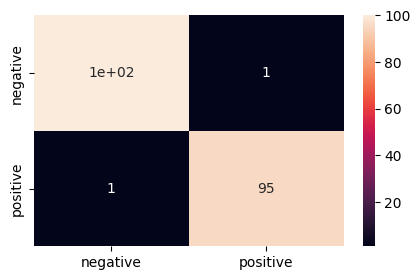

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       101
    positive       0.99      0.99      0.99        96

    accuracy                           0.99       197
   macro avg       0.99      0.99      0.99       197
weighted avg       0.99      0.99      0.99       197

Testing Accuracy


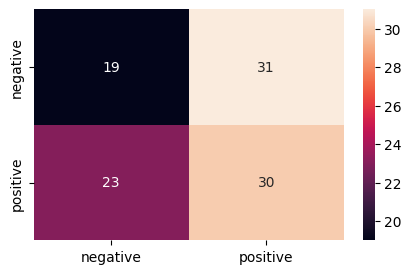

              precision    recall  f1-score   support

    negative       0.45      0.38      0.41        50
    positive       0.49      0.57      0.53        53

    accuracy                           0.48       103
   macro avg       0.47      0.47      0.47       103
weighted avg       0.47      0.48      0.47       103




Training for XR_WRIST
negative
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
Total 99 Images is Readed
positive
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,
Total 102 Imag

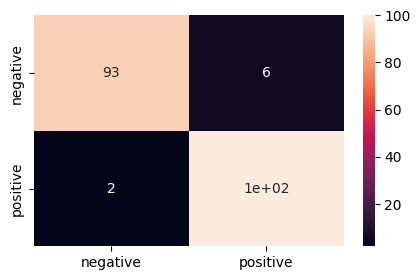

              precision    recall  f1-score   support

    negative       0.98      0.94      0.96        99
    positive       0.94      0.98      0.96       102

    accuracy                           0.96       201
   macro avg       0.96      0.96      0.96       201
weighted avg       0.96      0.96      0.96       201

Testing Accuracy


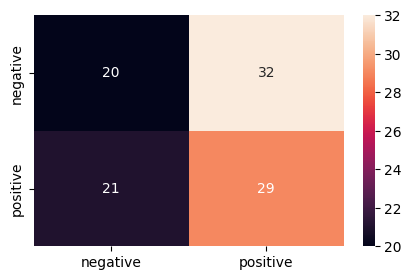

              precision    recall  f1-score   support

    negative       0.49      0.38      0.43        52
    positive       0.48      0.58      0.52        50

    accuracy                           0.48       102
   macro avg       0.48      0.48      0.48       102
weighted avg       0.48      0.48      0.48       102



In [12]:
TrainTheModel(Architecture,epochs=10)